In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, BatchNormalization, Dropout, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imutils import paths
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix
import os
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

#### Tiền xử lí dữ liệu 

In [6]:
# Lấy các đường dẫn đến ảnh.
# image_path = list(paths.list_images('data/dogs-vs-cats/train/train'))
image_path = list(paths.list_images('data/dogs-vs-cats/train/train'))

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh
random.shuffle(image_path)

# Chỉ lấy 5000 dòng đầu tiên (10000 ảnh)
image_path = image_path[:10000]
# print(image_path)

In [7]:
labels = [p.split(os.path.sep)[-1] for p in image_path]
labels = [label.split('.')[-3] for label in labels]
print(labels)
# Chuyển tên các loài hoa thành số
le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

['dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog'

In [8]:
# Load ảnh và resize về đúng kích thước mà VGG 16 cần là (224,224)
list_image = []
for (j, imagePath) in enumerate(image_path):
    # Load ảnh và resize về kích thước (224, 224)
    image = load_img(imagePath, target_size=(224, 224))
    
    # Chuyển ảnh thành mảng numpy
    image = img_to_array(image)
    
    # Mở rộng chiều của mảng numpy
    image = np.expand_dims(image, 0)
    
    # Tiền xử lý ảnh theo tiêu chuẩn của mô hình VGG16
    image = imagenet_utils.preprocess_input(image)
    
    # Thêm ảnh đã tiền xử lý vào danh sách
    list_image.append(image)
    
# Chuyển danh sách các ảnh thành mảng numpy một chiều
list_image = np.vstack(list_image)

In [9]:
# print(list_image)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, test_size=0.2, random_state=42)

#### Xây dựng Model

In [11]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense
from keras.models import Model

def residual_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Add()([x, input_tensor])
    x = Activation(activation)(x)
    return x

input_tensor = Input(shape=(X_train.shape[1:]))
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Building Residual blocks
for _ in range(3):  # Example: 3 residual blocks
    x = residual_block(x, 32)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)

#### Fit model

In [12]:
# Tạo đối tượng optimizer
optimizer = tf.keras.optimizers.Adam()

# Thiết lập ModelCheckpoint
save_best_only = True
checkpoint = ModelCheckpoint('models/model2-ResNet50-{epoch:03d}.keras',  
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

# Xây dựng quy trình huấn luyện
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - accuracy: 0.5489 - loss: 236.5118
Epoch 1: val_loss improved from inf to 62.20953, saving model to models/model-ResNet50-001.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 198s 969ms/step - accuracy: 0.5491 - loss: 235.9636 - val_accuracy: 0.5806 - val_loss: 62.2095
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7092 - loss: 28.4557
Epoch 2: val_loss did not improve from 62.20953
200/200 ━━━━━━━━━━━━━━━━━━━━ 181s 905ms/step - accuracy: 0.7091 - loss: 28.4662 - val_accuracy: 0.5256 - val_loss: 128.6898
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.6625 - loss: 53.7467
Epoch 3: val_loss improved from 62.20953 to 51.33354, saving model to models/model-ResNet50-003.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 182s 911ms/step - accuracy: 0.6626 - loss: 53.6629 - val_accuracy: 0.6181 - val_loss: 51.3335
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.7592 - loss: 17.0253
Epoch 4: val_loss improve

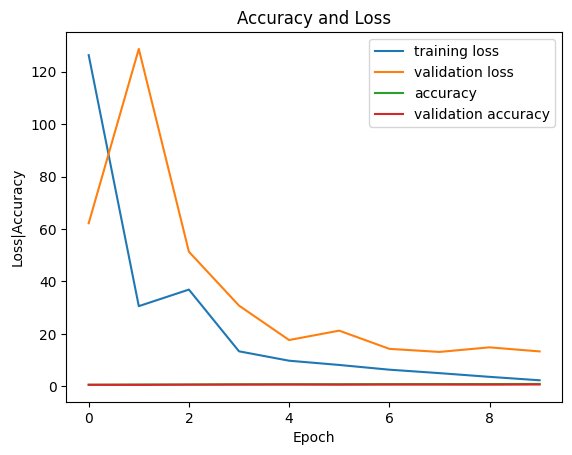

In [13]:
# Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy') # sử dụng từ khóa accuracy thay vì acc
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy') # sử dụng từ khóa val_accuracy thay vì val_acc
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [15]:
from keras.models import load_model
model = load_model('models/model-ResNet50-008.keras')

score = model.evaluate(X_test, y_test, verbose=1)
print(score)

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.6368 - loss: 13.5894
[13.01821517944336, 0.6549999713897705]


In [18]:
# model.summary()

In [16]:
# Đánh giá model
preds = model.predict(X_test) # DỰ ĐOÁN VÀ ĐÁNH GIÁ 
preds = np.argmax(preds, axis=1)
print(classification_report(y_test, preds))

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step
              precision    recall  f1-score   support

           0       0.70      0.55      0.62      1006
           1       0.63      0.76      0.69       994

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.66      0.66      0.65      2000



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


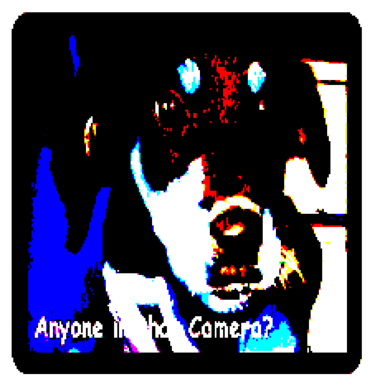

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Giá trị dự đoán:  0


In [17]:
# 10. Dự đoán ảnh
plt.imshow(X_test[0])
plt.axis('off')  
plt.show()

y_predict = model.predict(np.expand_dims(X_test[0], axis=0))
print('Giá trị dự đoán: ', np.argmax(y_predict))

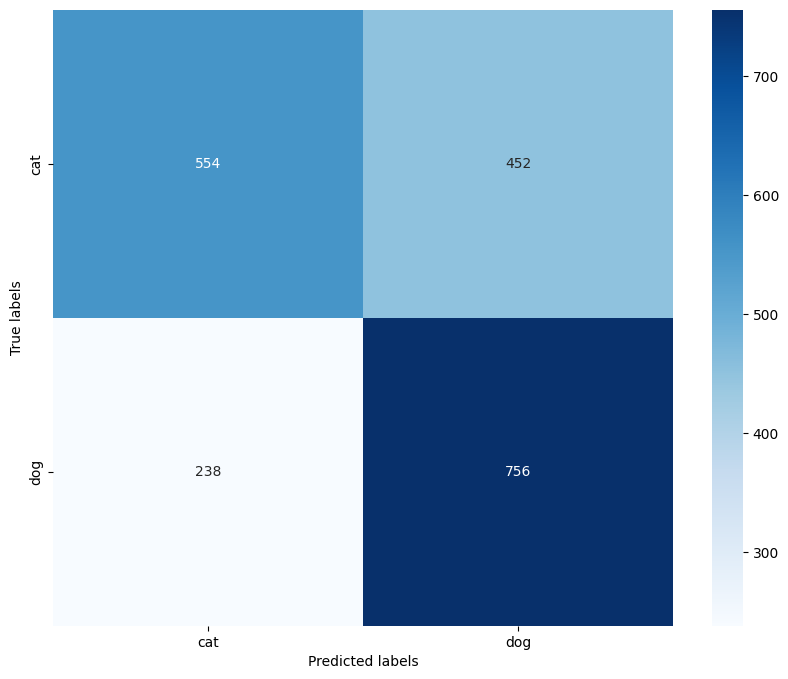

In [19]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, preds)

# Chuyển nhãn số thành tên 
label_names = le.inverse_transform(np.unique(y_test))
label_names = [label.split('/')[-1] for label in label_names]
# Sắp xếp lại ma trận nhầm lẫn
sorted_cm = cm[np.argsort(label_names)][:, np.argsort(label_names)]

# Tạo dataframe từ ma trận nhầm lẫn đã sắp xếp lại
df_cm = pd.DataFrame(sorted_cm, index=label_names, columns=label_names)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
